In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

daily = pd.read_csv("ml_ready_daily_sentiment.csv")
daily['Date'] = pd.to_datetime(daily['Date'])
daily.head()

,Date,vader_score,CP,return,sentiment_lag_1,sentiment_lag_2,sentiment_lag_3,sentiment_lag_4,sentiment_lag_5,volatility_20d,direction
0,2008-03-27,-0.61240,1325.76,-0.003742,-0.27320,0.5106,0.0000,-0.4010,0.0000,0.027094,0
1,2008-04-02,0.52670,1367.53,0.031506,-0.61240,-0.2732,0.5106,0.0000,-0.4010,0.028232,1
2,2008-04-07,-0.29600,1372.54,0.003664,0.52670,-0.6124,-0.2732,0.5106,0.0000,0.027900,1
3,2008-04-16,0.21075,1364.71,-0.005705,-0.29600,0.5267,-0.6124,-0.2732,0.5106,0.027906,0
4,2008-04-22,0.00000,1375.94,0.008229,0.21075,-0.2960,0.5267,-0.6124,-0.2732,0.027911,1


In [4]:
features = [
    'sentiment_lag_1',
    'sentiment_lag_2',
    'sentiment_lag_3',
    'sentiment_lag_4',
    'sentiment_lag_5',
    'volatility_20d'
]

X = daily[features]
y = daily['direction']


In [5]:
split = int(len(daily) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [8]:
log_model_bal = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

log_model_bal.fit(X_train, y_train)
log_preds_bal = log_model_bal.predict(X_test)

print("Balanced Logistic Accuracy:", accuracy_score(y_test, log_preds_bal))
print(classification_report(y_test, log_preds_bal))



Balanced Logistic Accuracy: 0.5071633237822349
              precision    recall  f1-score   support

           0       0.49      0.45      0.47       339
           1       0.52      0.56      0.54       359

    accuracy                           0.51       698
   macro avg       0.51      0.51      0.50       698
weighted avg       0.51      0.51      0.51       698



In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=20,
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]



In [19]:
from sklearn.metrics import accuracy_score, classification_report


rf_preds = (rf_probs > 0.5).astype(int)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.5128939828080229
              precision    recall  f1-score   support

           0       0.43      0.01      0.02       339
           1       0.51      0.99      0.68       359

    accuracy                           0.51       698
   macro avg       0.47      0.50      0.35       698
weighted avg       0.47      0.51      0.36       698



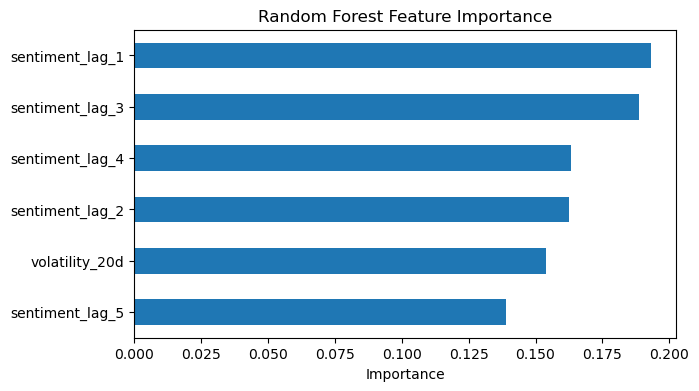

In [21]:
importance = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values()

importance.plot(kind='barh', figsize=(7,4))
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()


In [20]:
threshold = 0.55   # conservative

daily_test = daily.iloc[split:].copy()
daily_test['rf_prob'] = rf_probs

daily_test['signal'] = (daily_test['rf_prob'] > threshold).astype(int)
print("Trade frequency:", daily_test['signal'].mean())


Trade frequency: 0.5401146131805158


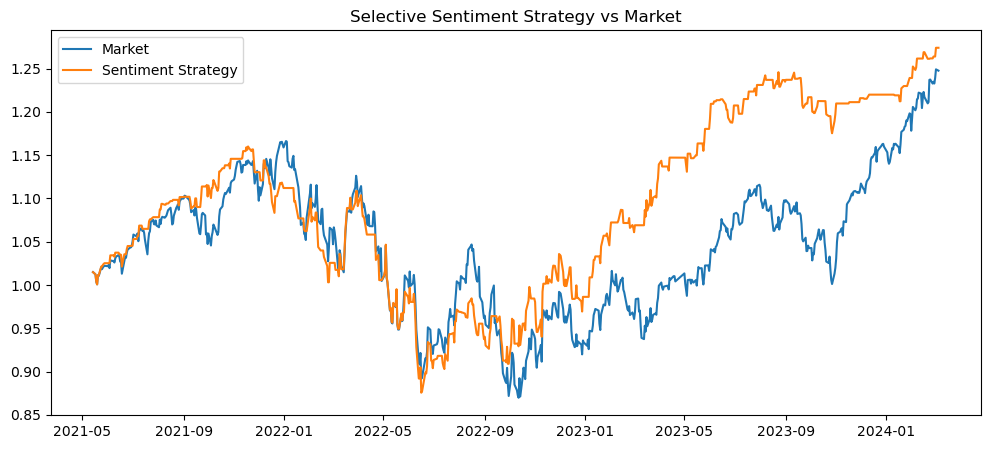

In [16]:
daily_test['strategy_return'] = daily_test['signal'] * daily_test['return']
daily_test['market_cum'] = (1 + daily_test['return']).cumprod()
daily_test['strategy_cum'] = (1 + daily_test['strategy_return']).cumprod()
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_test['Date'], daily_test['market_cum'], label='Market')
plt.plot(daily_test['Date'], daily_test['strategy_cum'], label='Sentiment Strategy')
plt.legend()
plt.title("Selective Sentiment Strategy vs Market")
plt.show()



In [17]:
def sharpe_ratio(returns, risk_free_rate=0):
    return (returns.mean() - risk_free_rate) / returns.std()

print("Market Sharpe:", sharpe_ratio(daily_test['return']))
print("Strategy Sharpe:", sharpe_ratio(daily_test['strategy_return']))


Market Sharpe: 0.03408037336229912
Strategy Sharpe: 0.042670974108856286
